# Import Libraries

In [ ]:
from keras.preprocessing import image
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras import models
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import cv2
from keras import backend as K
K.clear_session()
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load MobileNetV2

In [ ]:
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
mobile_base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Load & Preprocess Image

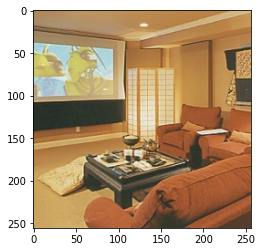

In [ ]:
img_path = '/content/drive/<path>' # set source path
img = mpimg.imread(img_path)
plt.imshow(img)

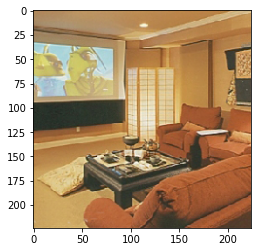

In [ ]:
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [ ]:
def preprocess_img_shape(img):
  img = image.img_to_array(img) # convert image to numpy array
  return np.expand_dims(img, axis=0) # reshape the image into batch so that the model could accept it

In [ ]:
input_img = preprocess_img_shape(img)
input_img.shape

(1, 224, 224, 3)

In [ ]:
input_img = preprocess_input(input_img)

# Make Prediction

In [ ]:
pred = mobile_base_model.predict(input_img)

In [ ]:
pred.shape # the input shape is supposed to be (samples, 1000) -> 1000 classes of ImageNet

(1, 1000)

In [ ]:
prediction = pd.DataFrame(decode_predictions(pred, top=3)[0],columns=['col','Class','Probability']).iloc[:,1:] # top = 5 by default
print('Prediction:', prediction.loc[0, 'Class'])

Prediction: home_theater


Text(0.5, 1.0, 'Top 3 Predictions')

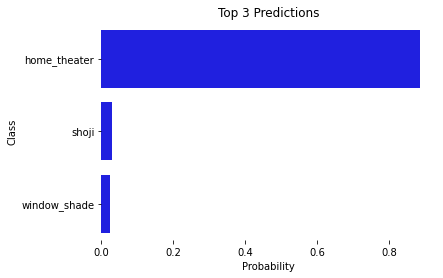

In [ ]:
chart = sns.barplot(x='Probability', y='Class', data=prediction, color='blue')
sns.set_style(style='white')
chart.grid(False)
chart.spines['top'].set_visible(False)
chart.spines['right'].set_visible(False)
chart.spines['bottom'].set_visible(False)
chart.spines['left'].set_visible(False)
chart.set_title('Top 3 Predictions')

# Get Index of Prediction

In [ ]:
argmax = np.argmax(pred[0])

In [ ]:
output = mobile_base_model.output[:, argmax]

# Model Architecture

In [ ]:
mobile_base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
last_conv_layer = mobile_base_model.get_layer('Conv_1')

In [ ]:
heatmap_model = models.Model([mobile_base_model.inputs], [last_conv_layer.output, mobile_base_model.output])

with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(input_img)
    loss = predictions[:, np.argmax(predictions[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat

print(heatmap.shape)

(1, 7, 7)


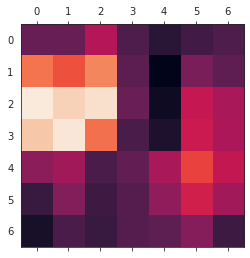

In [ ]:
plt.matshow(heatmap.squeeze())
plt.show()

# Load Image & Resize Heatmap

In [ ]:
heatmap = heatmap.squeeze()
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

In [ ]:
heatmap.shape

(256, 256)

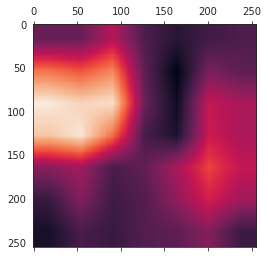

In [ ]:
plt.matshow(heatmap)
plt.show()

# Convert Heatmap to RGB 

In [ ]:
heatmap *= 255
heatmap = heatmap.astype(np.uint8)

In [ ]:
heatmap.shape

(256, 256)

In [ ]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Apply Heatmap Intensity Factor

In [ ]:
hif = .9
superimposed_img = heatmap * hif + img

In [ ]:
superimposed_img.shape

(256, 256, 3)

# Plot

In [ ]:
output_path = '/content/drive/<path>' # set destination path
cv2.imwrite(output_path, superimposed_img)

img = mpimg.imread(output_path)

Text(0.5, 1.0, 'home_theater')

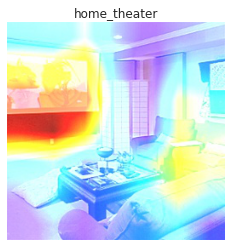

In [ ]:
plt.imshow(img)
plt.axis('off')
plt.title(prediction.loc[0, 'Class'])